In [1]:
from deepface.detectors.FaceDetector import detect_faces,build_model
from cv2 import imread,imshow,waitKey,FONT_HERSHEY_SIMPLEX,rectangle,putText
from deepface.DeepFace import represent
from elasticsearch import Elasticsearch
import os


In [2]:
es = Elasticsearch("http://localhost:9200")


In [3]:
identities = {}
directory="C:\\Users\\iheb9\\PycharmProjects\\imagesscrapping\\imgs\\"
l=[]
for filename in os.listdir(directory):
    name=filename.split('.')[0][:-1]
    if name not in identities.keys():  
        l=[]
    if  filename.split('.')[0][:-1]==name:
        l.append(directory+filename)
        identities[name]=l


In [4]:
def comparefaces(img_path_to_comp,threshhold):
    names = []
    detector_name = "mtcnn"
    detector = build_model(detector_name)
    models = ["Facenet512", "Dlib", "ArcFace"]
    # compare_faces( using 1 feature vector):
    img1 = imread(img_path_to_comp)
    obj1 = detect_faces(detector, detector_name, img1, align=True)
    i = 0
    for facei in obj1:
        i += 1
        embedding_dlib1 = represent(facei[0], model_name=models[1], enforce_detection=False ,align=True)
        embedding_arcface1 = represent(facei[0], model_name=models[2], enforce_detection=False,align=True)
        embedding_facenet1 = represent(facei[0], model_name=models[0], enforce_detection=False,align=True)

        #print("Face", i, "")
        queryDlib = {

            "query": {
                "elastiknn_nearest_neighbors": {
                    "field": "Dlib",
                    "vec": {
                        "values": embedding_dlib1
                    },
                    "similarity": "l2",
                    "model": "exact",

                }
            }

        }
        queryFacenet = {

            "query": {
                "elastiknn_nearest_neighbors": {
                    "field": "Facenet512",
                    "vec": {
                        "values": embedding_facenet1
                    },
                    "similarity": "cosine",
                    "model": "exact",

                }
            }

        }
        queryArcface = {

            "query": {
                "elastiknn_nearest_neighbors": {
                    "field": "ArcFace",
                    "vec": {
                        "values": embedding_arcface1
                    },
                    "similarity": "cosine",
                    "model": "exact",

                }
            }

        }
        responseDlib = es.search(index="celebfaces", body=queryDlib)
        responseFacenet = es.search(index="celebfaces", body=queryFacenet)
        responseArcface = es.search(index="celebfaces", body=queryArcface)
        matches = []
        for hit in responseDlib['hits']['hits']:
     
            matches.append((hit['_source']['fname']+' '+hit['_source']['lname'], 1-float(hit['_score']), 'dlib'))

        for hit in responseFacenet['hits']['hits']:
          
            matches.append((hit['_source']['fname']+' '+hit['_source']['lname'], float(hit['_score'])-1, 'facenet'))

        for hit in responseArcface['hits']['hits']:
      
            matches.append((hit['_source']['fname']+' '+hit['_source']['lname'], float(hit['_score'])-1, 'arcface'))

        dist = [x[1] for x in matches]
        item = matches[dist.index(max(dist))]
        if item[1]<threshhold:
            #print("==> This face is unkown")
            names.append('unkown')
            return('unknown',[item[1]])
        else:
            names.append(item[0])
            #print("==> This face  matches with ", item[0], ",the score is", item[1], ' using ', item[2])
            #print("there are ", len(obj1), " faces")
        return ((item[0],item[1]))


In [5]:
comparefaces("C:\\Users\\iheb9\\PycharmProjects\\imagesscrapping\\imgs\\Adele Laurie1.jpg",0.5)

('Adele Laurie', 0.5370695999999999)

In [6]:
import matplotlib.pyplot as plt

In [7]:
queryName={
  "query": {
    "match_all": {
    }
  },
    "size":1000
}

responseName = es.search(index="celebfaces", body=queryName)
names = []
for hit in responseName['hits']['hits']:
    names.append(hit['_source']['fname']+' '+hit['_source']['lname'])
print(names)


['billie eilish', 'cristiano ronaldo', 'dwayne johnson', 'jennifer lawrence', 'karim benzema', 'lionel messi', 'neymar jr', 'Adele Laurie', 'andreas inesta', 'billie eilish', 'carlo ancelotti', 'celine dion', 'cristiano ronaldo', 'david alaba', 'dwayne johnson', 'jennifer lawrence', 'karim benzema', 'lionel messi', 'neymar jr', 'robert lewandowski', 'sergio ramos', 'toni kroos', 'zinedine zidane']


In [8]:
x=[]
yacc=[]
yprec=[]
yrec=[]
yroc=[]
threshhold=0
while (threshhold<1):
    TP=0
    TN=0
    FP=0
    FN=0
    print(threshhold)
    for item in identities:
        for e in identities[item]:
            result=comparefaces(e,threshhold)
            if(result[0].lower()==item):
                #print(result[0],item)
                TP+=1
            if (result[0].lower()!=item and result[0].lower()!='unknown'):
                #print(result[0],item)
                FP+=1
            if (result[0].lower()=='unknown' and item not in names):
                TN+=1
            if(result[0].lower()=='unknown' and item in names):
                FN+=1
    accuracy=(TP+TN)/(TP+TN+FP+FN)
    precision=(TP)/(TP+FP)
    recall=(TP)/(TP+FN)
    TPR=(TP)/(TP+FN)
    FPR=(FP)/(FP+TN)
    x.append(threshhold) 
    yroc.append(abs(TPR+FPR-1))
    yacc.append(accuracy)
    yprec.append(precision)
    yrec.append(recall)
    threshhold+=0.01



0
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
0.4100000000000002
0.4200000000000002
0.4300000000000002
0.4400000000000002
0.45000000000000023
0.46000000000000024
0.47000000000000025
0.48000000000000026
0.49000000000000027
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.600

Text(0.5, 1.0, 'recall graph')

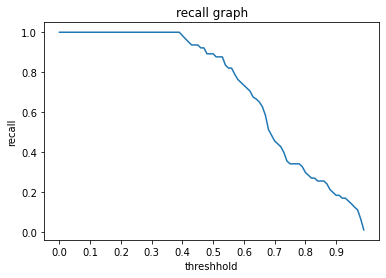

In [9]:
import numpy as np
plt.plot(x, yrec)
plt.xlabel('threshhold') 
plt.ylabel('recall') 
plt.xticks(np.arange(0, 1, 0.1))

plt.title("recall graph")

In [10]:
import numpy as np

0.47000000000000025


Text(0.5, 1.0, 'accuracy graph')

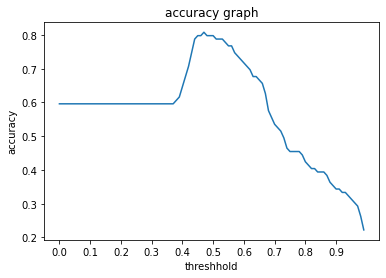

In [11]:
plt.plot(x, yacc)

plt.xlabel('threshhold') 
plt.ylabel('accuracy') 
plt.xticks(np.arange(0, 1, 0.1))
z=zip(yacc,x)
d=dict(z)
print(d[max(yacc)])
plt.title("accuracy graph")

on the accuracy plot the maximum is 0.47

Text(0.5, 1.0, 'Precision graph')

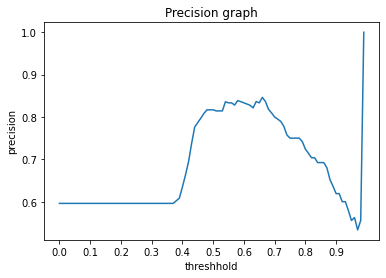

In [12]:
plt.plot(x, yprec)
plt.xlabel('threshhold') 
plt.ylabel('precision') 
plt.xticks(np.arange(0, 1, 0.1))

plt.title("Precision graph")

0.6300000000000003


Text(0.5, 1.0, 'graph')

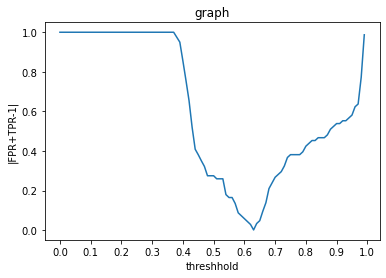

In [16]:
plt.plot(x, yroc)
plt.xlabel('threshhold') 
plt.ylabel('|FPR+TPR-1|') 
plt.xticks(np.arange(0, 1.1, 0.1))
z=zip(yroc,x)
d=dict(z)
print(d[min(yroc)])
plt.title("graph")

on the roc curve the minimum is 0.63